<a href="https://colab.research.google.com/github/gsurend4/BackPropogration/blob/main/Intro_to_BackPropogation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
class Value:
    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return (f'Value(data = {self.data})')

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out =  Value(self.data * other.data, (self, other), '*' )
        return out

In [ ]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10, label = 'c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd' # (a.__mul__(b)).__add__(c) Interally python call this way

d

Value(data = 4.0)

In [ ]:
# It is an API from graphviz

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

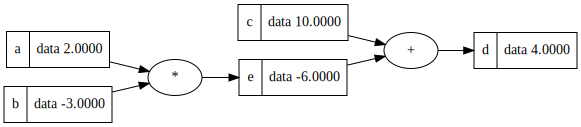

In [ ]:
draw_dot(d)